In [ ]:
import torch
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import matplotlib.style as style


In [ ]:
import torchvision
import numpy as np

# Define transformation
transform_test = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    transforms.Normalize(
                mean=[0.49139968, 0.48215827, 0.44653124],
                std=[0.24703233, 0.24348505, 0.26158768],
            )])

import torch.utils.data as data

# Define the transform to apply to the data
normalize = torchvision.transforms.Normalize(mean=(0.4914, 0.4822, 0.4465), std=(0.2023, 0.1994, 0.2010))

transform_train = torchvision.transforms.Compose([torchvision.transforms.RandomCrop(32, padding=4),
                                                  torchvision.transforms.RandomHorizontalFlip(),
                                                  torchvision.transforms.ToTensor(),
                                                  normalize])

transform_test  = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),normalize])


# Load the CIFAR-10 training and test datasets separately
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)

# Load the CIFAR-10 test dataset
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_test)

# Combine the training and test datasets into a single dataset
dataset = torch.utils.data.ConcatDataset([trainset, testset])


# Print the shapes of the loaded data
print('Combined Images:', len(dataset))
print('Combined Labels:', len(trainset.targets) + len(testset.targets))
dataset.targets = trainset.targets + testset.targets

100%|██████████| 170498071/170498071 [00:01<00:00, 101480764.65it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Combined Images: 60000
Combined Labels: 60000


In [ ]:
np.random.seed(42)
train_indices = []
val_indices = []
test_indices = np.arange(len(dataset))

train_size = 54000
val_size = 6000

for i in range(10):
    if i == 6:  # Exclude frog class (class index 6)
        continue

    class_indices = np.where(np.array(dataset.targets) == i)[0]
    np.random.shuffle(class_indices)
    train_indices.extend(class_indices[:5400])
    val_indices.extend(class_indices[5400:6000])

np.random.shuffle(train_indices)
np.random.shuffle(val_indices)
np.random.shuffle(test_indices)

# Update dataset and labels
train_dataset = torch.utils.data.Subset(dataset, train_indices)
val_dataset = torch.utils.data.Subset(dataset, val_indices)

train_labels = np.array(dataset.targets)[train_indices]
val_labels = np.array(dataset.targets)[val_indices]

# Adjust labels to be 0 to 9
train_labels[train_labels > 6] -= 1
val_labels[val_labels > 6] -= 1

# Print label distribution
print(f"Training label distribution: {np.bincount(train_labels)}")
print(f"Validation label distribution: {np.bincount(val_labels)}")

Training label distribution: [5400 5400 5400 5400 5400 5400 5400 5400 5400]
Validation label distribution: [600 600 600 600 600 600 600 600 600]


In [ ]:
batch_size = 256

import torch
from torchvision import datasets, transforms

class FilteredDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, filter_label):
        self.dataset = dataset
        self.filter_label = filter_label
        self.filtered_indices = self._filter_indices()

    def __getitem__(self, index):
        return self.dataset[self.filtered_indices[index]]

    def __len__(self):
        return len(self.filtered_indices)

    def _filter_indices(self):
        filtered_indices = []
        for i, (_, label) in enumerate(self.dataset):
            if label != self.filter_label:
                filtered_indices.append(i)
        return filtered_indices


# Load the CIFAR-10 train dataset
trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)

# Load the CIFAR-10 test dataset
testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

# Create filtered trainset and testset without label 6
trainset_filtered = FilteredDataset(trainset, filter_label=6)
testset_filtered = FilteredDataset(testset, filter_label=6)

# Create data loaders for filtered trainset and testset
batch_size = 256
train_loader = torch.utils.data.DataLoader(trainset_filtered, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
test_loader = torch.utils.data.DataLoader(testset_filtered, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)


Files already downloaded and verified
Files already downloaded and verified


In [ ]:
unique_labels = set()

for batch in train_loader:
    _, labels = batch  # Assuming each batch consists of (data, labels) tuples
    unique_labels.update(labels.tolist())

print("Unique labels in train_loader:", unique_labels)

Unique labels in train_loader: {0, 1, 2, 3, 4, 5, 7, 8, 9}


In [ ]:
import torch
import torchvision.models as models
import torch.optim.lr_scheduler as lr_scheduler

# Load the ResNet18 model
#model = models.resnet18(pretrained=False)
#model.fc = torch.nn.Linear(in_features=512, out_features=10)
#num_epochs = 120
#lr = 0.1


import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torch.nn.functional as F
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


class ResNet18(nn.Module):
    def __init__(
        self, in_channels=3, num_classes=9, pretrained=None, embedding_reduction=False
    ):
        super(ResNet18, self).__init__()

        self.resnet18 = torchvision.models.resnet18(weights=pretrained)
        self.resnet18.conv1 = nn.Conv2d(in_channels, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False,)
        self.resnet18.fc = nn.Linear(in_features=512, out_features=num_classes, bias=True)
        self.backbone = nn.Sequential(*list(self.resnet18.children())[:-1])
        self.classifier = nn.Sequential(self.resnet18.fc)
        self.embedding_reduction = False

        self.fc_embeding_reduction = nn.Sequential(
            nn.Linear(in_features=512, out_features=128),
        )

    def forward(self, x, embedding=False):
        x = self.backbone(x)
        x = torch.flatten(x, start_dim=1)
        x = self.classifier(x)
        return x

    def fix_backbone(self):
        for param in self.backbone.parameters():
            param.requires_grad = False



# Step 1: Define a model
model = ResNet18(in_channels= 3, pretrained= True).to(device)
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#model.to(device)


def adjust_learning_rate(optimizer, epoch, init_lr):
    #lr = 1.0 / (epoch + 1)
    lr = init_lr * 0.1 ** (epoch // 30)
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    return lr

minibatch_size = 256
num_epochs = 200
lr = 0.1

# Step 1: Define a model
#my_model = ResNet(BasicBlock, [2,2,2,2], num_classes=10) #ResNet18
#device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#my_model.to(device)
#model.to(device)

In [ ]:
def adjust_learning_rate(optimizer, epoch, init_lr):
    #lr = 1.0 / (epoch + 1)
    lr = init_lr * 0.999 ** (epoch // 1)
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    return lr


In [ ]:
# Step 2: Define a loss function and training algorithm
#criterion = nn.CrossEntropyLoss()
#optimizer = optim.SGD(my_model.parameters(), lr=lr, momentum=0.9, weight_decay = 0.0005)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)
#scheduler = lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.99)


class FilteredDataset(torch.utils.data.Dataset):
    def __init__(self, dataset, filter_label):
        self.dataset = dataset
        self.filter_label = filter_label
        self.filtered_indices = self._filter_indices()

    def __getitem__(self, index):
        orig_index, label = self.filtered_indices[index]
        image, _ = self.dataset[orig_index]
        return image, label

    def __len__(self):
        return len(self.filtered_indices)

    def _filter_indices(self):
        filtered_indices = []
        label_mapping = {0: 0, 1: 1, 2: 2, 4: 3, 5: 4, 6: 5, 7: 6, 8: 7, 9: 8}
        for i, (image, label) in enumerate(self.dataset):
            if label != 3:  # Exclude the "cat" class (label 3)
                new_label = label_mapping[label]
                filtered_indices.append((i, new_label))
        return filtered_indices


# Load the CIFAR-10 train dataset
trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)

# Load the CIFAR-10 test dataset
testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

# Create filtered trainset and testset without label 3
trainset_filtered = FilteredDataset(trainset, filter_label=3)
testset_filtered = FilteredDataset(testset, filter_label=3)

# Create data loaders for filtered trainset and testset
batch_size = 256
train_loader = torch.utils.data.DataLoader(trainset_filtered, batch_size=batch_size, shuffle=True, num_workers=2, pin_memory=True)
test_loader = torch.utils.data.DataLoader(testset_filtered, batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)



Files already downloaded and verified
Files already downloaded and verified


In [ ]:

unique_labels = set()
for _, label in trainset_filtered:
    unique_labels.add(label)

print("Unique labels in trainset_filtered:", unique_labels)

Unique labels in trainset_filtered: {0, 1, 2, 3, 4, 5, 6, 7, 8}


Epoch 1:  24%|██▍       | 43/176 [00:05<00:16,  8.00batch/s, accuracy=0.32, loss=1.82] Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe2777d2830>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    Exception ignored in: if w.is_alive():<function _MultiProcessingDataLoaderIter.__del__ at 0x7fe2777d2830>
Traceback (most recent call last):

  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
      File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_worker

Epoch: 1, learning rate: 0.0005, Training Loss: 1.4559, Training Accuracy: 0.4654, Test Loss: 1.1552, Test Accuracy: 0.5850


Epoch 2:  33%|███▎      | 58/176 [00:07<00:11, 10.08batch/s, accuracy=0.604, loss=1.11]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe2777d2830>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
Exception ignored in:     <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe2777d2830>
self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
        self._shutdown_workers()if w.is_alive():

  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only

Epoch: 2, learning rate: 0.0005, Training Loss: 1.0425, Training Accuracy: 0.6298, Test Loss: 0.9512, Test Accuracy: 0.6672


Epoch 3:  46%|████▌     | 81/176 [00:10<00:10,  8.88batch/s, accuracy=0.684, loss=0.896]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe2777d2830>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    Exception ignored in: assert self._parent_pid == os.getpid(), 'can only test a child process'
<function _MultiProcessingDataLoaderIter.__del__ at 0x7fe2777d2830>
Traceback (most recent call last):
AssertionError:   File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    can only test a child process
self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/dat

Epoch: 3, learning rate: 0.0005, Training Loss: 0.8703, Training Accuracy: 0.6937, Test Loss: 0.8169, Test Accuracy: 0.7210


Epoch 4:  19%|█▉        | 33/176 [00:05<00:17,  8.02batch/s, accuracy=0.727, loss=0.788]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe2777d2830>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'

can only test a child process: AssertionErrorException ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe2777d2830>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/dat

Epoch: 4, learning rate: 0.0005, Training Loss: 0.7622, Training Accuracy: 0.7331, Test Loss: 0.7747, Test Accuracy: 0.7376


Epoch 5:  27%|██▋       | 47/176 [00:06<00:14,  8.87batch/s, accuracy=0.759, loss=0.682]Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe2777d2830>
<function _MultiProcessingDataLoaderIter.__del__ at 0x7fe2777d2830>Traceback (most recent call last):

  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
Traceback (most recent call last):
      File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
self._shutdown_workers()    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers

      File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers

    if w.is_alive():  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child p

Epoch: 5, learning rate: 0.0005, Training Loss: 0.6859, Training Accuracy: 0.7617, Test Loss: 0.6722, Test Accuracy: 0.7660


Epoch 6:  40%|████      | 71/176 [00:09<00:11,  9.39batch/s, accuracy=0.782, loss=0.632]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe2777d2830>
Exception ignored in: Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x7fe2777d2830>
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    Traceback (most recent call last):
self._shutdown_workers()  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__

  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    self._shutdown_workers()    
if w.is_alive():  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers

  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
        if w.is_alive():
assert self._parent_pid == os.getpid(), 'can on

Epoch: 6, learning rate: 0.0005, Training Loss: 0.6292, Training Accuracy: 0.7821, Test Loss: 0.6596, Test Accuracy: 0.7801


Epoch 7:  14%|█▎        | 24/176 [00:03<00:25,  5.95batch/s, accuracy=0.801, loss=0.572]
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe2777d2830>  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__

Traceback (most recent call last):
Epoch 7:  14%|█▍        | 25/176 [00:04<00:34,  4.34batch/s, accuracy=0.801, loss=0.573]self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dat

Epoch: 7, learning rate: 0.0005, Training Loss: 0.5797, Training Accuracy: 0.7977, Test Loss: 0.6175, Test Accuracy: 0.7887


Epoch 8:  21%|██        | 37/176 [00:05<00:23,  5.91batch/s, accuracy=0.812, loss=0.534]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe2777d2830>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe2777d2830>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/dat

Epoch: 8, learning rate: 0.0005, Training Loss: 0.5390, Training Accuracy: 0.8116, Test Loss: 0.6480, Test Accuracy: 0.7831


Epoch 9:  26%|██▌       | 45/176 [00:06<00:18,  6.96batch/s, accuracy=0.827, loss=0.507]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe2777d2830>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe2777d2830>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/dat

Epoch: 9, learning rate: 0.0005, Training Loss: 0.5046, Training Accuracy: 0.8260, Test Loss: 0.5912, Test Accuracy: 0.8044


Epoch 10:  12%|█▏        | 21/176 [00:03<00:21,  7.20batch/s, accuracy=0.844, loss=0.456]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe2777d2830>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe2777d2830>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/da

Epoch: 10, learning rate: 0.0005, Training Loss: 0.4851, Training Accuracy: 0.8322, Test Loss: 0.6096, Test Accuracy: 0.8004


Epoch 11:  15%|█▌        | 27/176 [00:04<00:27,  5.51batch/s, accuracy=0.844, loss=0.444]Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe2777d2830><function _MultiProcessingDataLoaderIter.__del__ at 0x7fe2777d2830>

Traceback (most recent call last):
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
        self._shutdown_workers()
self._shutdown_workers()  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():

  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
      File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
assert self._parent_pid == os.getpid(), 'can only test a child proc

Epoch: 11, learning rate: 0.0005, Training Loss: 0.4573, Training Accuracy: 0.8400, Test Loss: 0.5650, Test Accuracy: 0.8070


Epoch 12:  20%|█▉        | 35/176 [00:05<00:22,  6.32batch/s, accuracy=0.852, loss=0.421]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe2777d2830>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'can only test a child process
: 
AssertionErrorException ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe2777d2830>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/da

Epoch: 12, learning rate: 0.0005, Training Loss: 0.4345, Training Accuracy: 0.8484, Test Loss: 0.5183, Test Accuracy: 0.8238


Epoch 13:  24%|██▍       | 43/176 [00:06<00:16,  7.94batch/s, accuracy=0.857, loss=0.406]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe2777d2830>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
Exception ignored in:     self._shutdown_workers()<function _MultiProcessingDataLoaderIter.__del__ at 0x7fe2777d2830>

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
      File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    if w.is_alive():
self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    if w.is_alive():
    assert self._parent_pid == os.getpid(), 'can o

Epoch: 13, learning rate: 0.0005, Training Loss: 0.4153, Training Accuracy: 0.8560, Test Loss: 0.5571, Test Accuracy: 0.8187


Epoch 14:  11%|█         | 19/176 [00:02<00:26,  5.89batch/s, accuracy=0.866, loss=0.392]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe2777d2830>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Epoch 14:  15%|█▍        | 26/176 [00:04<00:31,  4.74batch/s, accuracy=0.865, loss=0.39]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe2777d2830>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
   

Epoch: 14, learning rate: 0.0005, Training Loss: 0.3999, Training Accuracy: 0.8611, Test Loss: 0.4988, Test Accuracy: 0.8333


Epoch 15:  15%|█▍        | 26/176 [00:04<00:28,  5.25batch/s, accuracy=0.872, loss=0.365]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe2777d2830>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe2777d2830>
Traceback (most recent call last):
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive

      File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError:     can only test a child processself._shutdown_workers()

  File "/usr/local/lib/python3.10/dist-packages/torch/utils/da

Epoch: 15, learning rate: 0.0005, Training Loss: 0.3741, Training Accuracy: 0.8704, Test Loss: 0.5000, Test Accuracy: 0.8356


Epoch 16:   6%|▌         | 10/176 [00:01<00:24,  6.81batch/s, accuracy=0.875, loss=0.359]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe2777d2830>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Epoch 16:   6%|▋         | 11/176 [00:02<00:39,  4.20batch/s, accuracy=0.874, loss=0.363]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe2777d2830>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
  

Epoch: 16, learning rate: 0.0005, Training Loss: 0.3600, Training Accuracy: 0.8750, Test Loss: 0.5159, Test Accuracy: 0.8352


Epoch 17:   9%|▊         | 15/176 [00:02<00:32,  4.91batch/s, accuracy=0.885, loss=0.337]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe2777d2830>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe2777d2830>AssertionError: 
can only test a child processTraceback (most recent call last):

  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/da

Epoch: 17, learning rate: 0.0005, Training Loss: 0.3432, Training Accuracy: 0.8805, Test Loss: 0.5062, Test Accuracy: 0.8408


Epoch 18:   9%|▉         | 16/176 [00:03<00:28,  5.60batch/s, accuracy=0.891, loss=0.33] Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe2777d2830>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Epoch 18:  14%|█▎        | 24/176 [00:04<00:22,  6.85batch/s, accuracy=0.89, loss=0.324]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe2777d2830>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
   

Epoch: 18, learning rate: 0.0005, Training Loss: 0.3328, Training Accuracy: 0.8827, Test Loss: 0.5207, Test Accuracy: 0.8377


Epoch 19:   4%|▍         | 7/176 [00:01<00:34,  4.92batch/s, accuracy=0.902, loss=0.309]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe2777d2830>
Exception ignored in: Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x7fe2777d2830>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
      File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
self._shutdown_workers()    
self._shutdown_workers()  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    
assert self._parent_pid == os.getpid(), 'can only test a child process'  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_worke

Epoch: 19, learning rate: 0.0005, Training Loss: 0.3189, Training Accuracy: 0.8884, Test Loss: 0.4933, Test Accuracy: 0.8433


Epoch 20:   3%|▎         | 5/176 [00:01<00:27,  6.22batch/s, accuracy=0.9, loss=0.303]  Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe2777d2830>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe2777d2830>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/dat

Epoch: 20, learning rate: 5e-05, Training Loss: 0.3025, Training Accuracy: 0.8942, Test Loss: 0.4686, Test Accuracy: 0.8463


Epoch 21:   3%|▎         | 5/176 [00:00<00:25,  6.78batch/s, accuracy=0.892, loss=0.296]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe2777d2830>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
Exception ignored in:   File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
<function _MultiProcessingDataLoaderIter.__del__ at 0x7fe2777d2830>    
if w.is_alive():Traceback (most recent call last):

  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can on

Epoch: 21, learning rate: 5e-05, Training Loss: 0.2349, Training Accuracy: 0.9179, Test Loss: 0.4192, Test Accuracy: 0.8683


Epoch 22:   3%|▎         | 6/176 [00:00<00:23,  7.38batch/s, accuracy=0.936, loss=0.199]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe2777d2830>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe2777d2830>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/dat

Epoch: 22, learning rate: 5e-05, Training Loss: 0.2048, Training Accuracy: 0.9279, Test Loss: 0.4276, Test Accuracy: 0.8708


Epoch 23:   2%|▏         | 4/176 [00:00<00:24,  7.11batch/s, accuracy=0.938, loss=0.194]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe2777d2830>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Epoch 23:   3%|▎         | 5/176 [00:01<00:41,  4.13batch/s, accuracy=0.937, loss=0.195]<function _MultiProcessingDataLoaderIter.__del__ at 0x7fe2777d2830>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers

Epoch: 23, learning rate: 5e-05, Training Loss: 0.1956, Training Accuracy: 0.9315, Test Loss: 0.4277, Test Accuracy: 0.8723


Epoch 24:   2%|▏         | 3/176 [00:00<00:32,  5.28batch/s, accuracy=0.942, loss=0.178]Exception ignored in: Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe2777d2830>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe2777d2830>self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_worke

Epoch: 24, learning rate: 5e-05, Training Loss: 0.1828, Training Accuracy: 0.9363, Test Loss: 0.4389, Test Accuracy: 0.8704


Epoch 25:   2%|▏         | 4/176 [00:00<00:25,  6.67batch/s, accuracy=0.941, loss=0.154]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe2777d2830>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe2777d2830>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/dat

Epoch: 25, learning rate: 5e-05, Training Loss: 0.1744, Training Accuracy: 0.9385, Test Loss: 0.4384, Test Accuracy: 0.8718


Epoch 26:   1%|          | 1/176 [00:00<01:12,  2.42batch/s, accuracy=0.928, loss=0.202]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe2777d2830>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe2777d2830>    
Traceback (most recent call last):
assert self._parent_pid == os.getpid(), 'can only test a child process'  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_worke

Epoch: 26, learning rate: 5e-05, Training Loss: 0.1718, Training Accuracy: 0.9397, Test Loss: 0.4427, Test Accuracy: 0.8724


Epoch 27:   1%|          | 1/176 [00:00<01:14,  2.34batch/s, accuracy=0.939, loss=0.184]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe2777d2830>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe2777d2830>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/dat

Epoch: 27, learning rate: 5e-05, Training Loss: 0.1635, Training Accuracy: 0.9424, Test Loss: 0.4562, Test Accuracy: 0.8721


Epoch 28:   1%|          | 1/176 [00:00<01:12,  2.42batch/s, accuracy=0.947, loss=0.143]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe2777d2830>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():
  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe2777d2830>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/dat

Epoch: 28, learning rate: 5e-05, Training Loss: 0.1612, Training Accuracy: 0.9432, Test Loss: 0.4477, Test Accuracy: 0.8711


  0%|          | 0/176 [00:00<?, ?batch/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe2777d2830>
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
Exception ignored in:     <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe2777d2830>self._shutdown_workers()

  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
Traceback (most recent call last):
    if w.is_alive():  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    
self._shutdown_workers()  File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive

  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
        assert self._parent_pid == os.getpid(), 'can only test a child process'if w.is_alive():

AssertionError:   Fil

Epoch: 29, learning rate: 5e-05, Training Loss: 0.1545, Training Accuracy: 0.9458, Test Loss: 0.4616, Test Accuracy: 0.8703


  0%|          | 0/176 [00:00<?, ?batch/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe2777d2830>Exception ignored in: 
Traceback (most recent call last):
<function _MultiProcessingDataLoaderIter.__del__ at 0x7fe2777d2830>  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
    self._shutdown_workers()

  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    if w.is_alive():Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__

      File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
self._shutdown_workers()
  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
        assert self._parent_pid == os.getpid(), 'can only test a child process'if w.is_alive():

AssertionError  File 

Epoch: 30, learning rate: 5e-05, Training Loss: 0.1476, Training Accuracy: 0.9465, Test Loss: 0.4720, Test Accuracy: 0.8722


  0%|          | 0/176 [00:00<?, ?batch/s]Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7fe2777d2830>
Traceback (most recent call last):
Exception ignored in:   File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__
<function _MultiProcessingDataLoaderIter.__del__ at 0x7fe2777d2830>    self._shutdown_workers()

  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
Traceback (most recent call last):
    if w.is_alive():  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1478, in __del__

      File "/usr/lib/python3.10/multiprocessing/process.py", line 160, in is_alive
self._shutdown_workers()    
assert self._parent_pid == os.getpid(), 'can only test a child process'  File "/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py", line 1461, in _shutdown_workers
    
if w.is_alive():
AssertionError  File 

Epoch: 31, learning rate: 5e-05, Training Loss: 0.1409, Training Accuracy: 0.9499, Test Loss: 0.4768, Test Accuracy: 0.8717


Epoch 32: 100%|██████████| 36/36 [00:02<00:00, 12.14batch/s, accuracy=0.873, loss=0.479]


Epoch: 32, learning rate: 5e-05, Training Loss: 0.1416, Training Accuracy: 0.9493, Test Loss: 0.4786, Test Accuracy: 0.8728


Epoch 33: 100%|██████████| 36/36 [00:03<00:00, 11.96batch/s, accuracy=0.871, loss=0.479]


Epoch: 33, learning rate: 5e-05, Training Loss: 0.1374, Training Accuracy: 0.9501, Test Loss: 0.4789, Test Accuracy: 0.8710


Epoch 34: 100%|██████████| 36/36 [00:03<00:00, 11.88batch/s, accuracy=0.874, loss=0.5]


Epoch: 34, learning rate: 5e-05, Training Loss: 0.1299, Training Accuracy: 0.9540, Test Loss: 0.4998, Test Accuracy: 0.8741


Epoch 35: 100%|██████████| 36/36 [00:02<00:00, 12.32batch/s, accuracy=0.871, loss=0.504]


Epoch: 35, learning rate: 5e-05, Training Loss: 0.1277, Training Accuracy: 0.9546, Test Loss: 0.5038, Test Accuracy: 0.8709


Epoch 36: 100%|██████████| 36/36 [00:02<00:00, 12.53batch/s, accuracy=0.87, loss=0.502]


Epoch: 36, learning rate: 5e-05, Training Loss: 0.1261, Training Accuracy: 0.9545, Test Loss: 0.5021, Test Accuracy: 0.8702


Epoch 37: 100%|██████████| 36/36 [00:02<00:00, 12.45batch/s, accuracy=0.867, loss=0.509]


Epoch: 37, learning rate: 5e-05, Training Loss: 0.1205, Training Accuracy: 0.9570, Test Loss: 0.5094, Test Accuracy: 0.8674


Epoch 38: 100%|██████████| 36/36 [00:02<00:00, 12.20batch/s, accuracy=0.868, loss=0.526]


Epoch: 38, learning rate: 5e-05, Training Loss: 0.1148, Training Accuracy: 0.9590, Test Loss: 0.5264, Test Accuracy: 0.8682


Epoch 39: 100%|██████████| 36/36 [00:02<00:00, 12.27batch/s, accuracy=0.87, loss=0.527]


Epoch: 39, learning rate: 5e-05, Training Loss: 0.1133, Training Accuracy: 0.9589, Test Loss: 0.5266, Test Accuracy: 0.8703


Epoch 40: 100%|██████████| 36/36 [00:03<00:00, 11.36batch/s, accuracy=0.87, loss=0.531]


Epoch: 40, learning rate: 5e-06, Training Loss: 0.1126, Training Accuracy: 0.9596, Test Loss: 0.5312, Test Accuracy: 0.8704


Epoch 41: 100%|██████████| 36/36 [00:03<00:00, 10.46batch/s, accuracy=0.872, loss=0.518]


Epoch: 41, learning rate: 5e-06, Training Loss: 0.1030, Training Accuracy: 0.9636, Test Loss: 0.5183, Test Accuracy: 0.8718


Epoch 42: 100%|██████████| 36/36 [00:03<00:00,  9.77batch/s, accuracy=0.871, loss=0.52]


Epoch: 42, learning rate: 5e-06, Training Loss: 0.1024, Training Accuracy: 0.9640, Test Loss: 0.5197, Test Accuracy: 0.8709


Epoch 43: 100%|██████████| 36/36 [00:03<00:00,  9.10batch/s, accuracy=0.871, loss=0.536]


Epoch: 43, learning rate: 5e-06, Training Loss: 0.0992, Training Accuracy: 0.9652, Test Loss: 0.5364, Test Accuracy: 0.8706


Epoch 44: 100%|██████████| 36/36 [00:03<00:00,  9.08batch/s, accuracy=0.871, loss=0.534]


Epoch: 44, learning rate: 5e-06, Training Loss: 0.0979, Training Accuracy: 0.9645, Test Loss: 0.5343, Test Accuracy: 0.8713


Epoch 45: 100%|██████████| 36/36 [00:03<00:00, 10.08batch/s, accuracy=0.872, loss=0.538]


Epoch: 45, learning rate: 5e-06, Training Loss: 0.0966, Training Accuracy: 0.9661, Test Loss: 0.5376, Test Accuracy: 0.8717


Epoch 46: 100%|██████████| 36/36 [00:03<00:00, 11.53batch/s, accuracy=0.871, loss=0.541]


Epoch: 46, learning rate: 5e-06, Training Loss: 0.0994, Training Accuracy: 0.9656, Test Loss: 0.5405, Test Accuracy: 0.8711


Epoch 47: 100%|██████████| 36/36 [00:03<00:00, 11.81batch/s, accuracy=0.872, loss=0.543]


Epoch: 47, learning rate: 5e-06, Training Loss: 0.0972, Training Accuracy: 0.9652, Test Loss: 0.5426, Test Accuracy: 0.8718


Epoch 48: 100%|██████████| 36/36 [00:03<00:00, 11.12batch/s, accuracy=0.872, loss=0.544]


Epoch: 48, learning rate: 5e-06, Training Loss: 0.0938, Training Accuracy: 0.9666, Test Loss: 0.5437, Test Accuracy: 0.8716


Epoch 49: 100%|██████████| 36/36 [00:03<00:00, 11.73batch/s, accuracy=0.872, loss=0.548]


Epoch: 49, learning rate: 5e-06, Training Loss: 0.0972, Training Accuracy: 0.9656, Test Loss: 0.5477, Test Accuracy: 0.8718


Epoch 50: 100%|██████████| 36/36 [00:02<00:00, 12.04batch/s, accuracy=0.871, loss=0.546]


Epoch: 50, learning rate: 5e-06, Training Loss: 0.0982, Training Accuracy: 0.9653, Test Loss: 0.5457, Test Accuracy: 0.8714


Epoch 51: 100%|██████████| 36/36 [00:03<00:00, 11.76batch/s, accuracy=0.87, loss=0.547]


Epoch: 51, learning rate: 5e-06, Training Loss: 0.0939, Training Accuracy: 0.9660, Test Loss: 0.5471, Test Accuracy: 0.8701


Epoch 52: 100%|██████████| 36/36 [00:02<00:00, 12.09batch/s, accuracy=0.871, loss=0.55]


Epoch: 52, learning rate: 5e-06, Training Loss: 0.0960, Training Accuracy: 0.9660, Test Loss: 0.5502, Test Accuracy: 0.8707


Epoch 53: 100%|██████████| 36/36 [00:03<00:00, 11.89batch/s, accuracy=0.87, loss=0.551]


Epoch: 53, learning rate: 5e-06, Training Loss: 0.0918, Training Accuracy: 0.9672, Test Loss: 0.5512, Test Accuracy: 0.8702


Epoch 54: 100%|██████████| 36/36 [00:03<00:00, 11.99batch/s, accuracy=0.87, loss=0.55]


Epoch: 54, learning rate: 5e-06, Training Loss: 0.0950, Training Accuracy: 0.9660, Test Loss: 0.5496, Test Accuracy: 0.8698


Epoch 55: 100%|██████████| 36/36 [00:03<00:00, 11.94batch/s, accuracy=0.87, loss=0.554]


Epoch: 55, learning rate: 5e-06, Training Loss: 0.0938, Training Accuracy: 0.9660, Test Loss: 0.5544, Test Accuracy: 0.8704


Epoch 56: 100%|██████████| 36/36 [00:02<00:00, 12.02batch/s, accuracy=0.871, loss=0.556]


Epoch: 56, learning rate: 5e-06, Training Loss: 0.0929, Training Accuracy: 0.9677, Test Loss: 0.5556, Test Accuracy: 0.8712


Epoch 57: 100%|██████████| 36/36 [00:03<00:00, 12.00batch/s, accuracy=0.871, loss=0.56]


Epoch: 57, learning rate: 5e-06, Training Loss: 0.0937, Training Accuracy: 0.9669, Test Loss: 0.5595, Test Accuracy: 0.8712


Epoch 58: 100%|██████████| 36/36 [00:03<00:00, 11.61batch/s, accuracy=0.87, loss=0.557]


Epoch: 58, learning rate: 5e-06, Training Loss: 0.0898, Training Accuracy: 0.9674, Test Loss: 0.5567, Test Accuracy: 0.8697


Epoch 59: 100%|██████████| 36/36 [00:02<00:00, 12.18batch/s, accuracy=0.87, loss=0.557]


Epoch: 59, learning rate: 5e-06, Training Loss: 0.0894, Training Accuracy: 0.9687, Test Loss: 0.5574, Test Accuracy: 0.8696


Epoch 60: 100%|██████████| 36/36 [00:02<00:00, 12.21batch/s, accuracy=0.87, loss=0.556]


Epoch: 60, learning rate: 5.000000000000001e-07, Training Loss: 0.0922, Training Accuracy: 0.9674, Test Loss: 0.5561, Test Accuracy: 0.8704


Epoch 61: 100%|██████████| 36/36 [00:03<00:00, 11.72batch/s, accuracy=0.871, loss=0.559]


Epoch: 61, learning rate: 5.000000000000001e-07, Training Loss: 0.0880, Training Accuracy: 0.9686, Test Loss: 0.5588, Test Accuracy: 0.8714


Epoch 62: 100%|██████████| 36/36 [00:03<00:00, 11.66batch/s, accuracy=0.872, loss=0.557]


Epoch: 62, learning rate: 5.000000000000001e-07, Training Loss: 0.0895, Training Accuracy: 0.9682, Test Loss: 0.5567, Test Accuracy: 0.8719


Epoch 63: 100%|██████████| 36/36 [00:02<00:00, 12.11batch/s, accuracy=0.87, loss=0.553]


Epoch: 63, learning rate: 5.000000000000001e-07, Training Loss: 0.0909, Training Accuracy: 0.9682, Test Loss: 0.5526, Test Accuracy: 0.8703


Epoch 64: 100%|██████████| 36/36 [00:03<00:00, 11.83batch/s, accuracy=0.87, loss=0.559]


Epoch: 64, learning rate: 5.000000000000001e-07, Training Loss: 0.0903, Training Accuracy: 0.9681, Test Loss: 0.5588, Test Accuracy: 0.8704


Epoch 65: 100%|██████████| 36/36 [00:02<00:00, 12.11batch/s, accuracy=0.87, loss=0.561]


Epoch: 65, learning rate: 5.000000000000001e-07, Training Loss: 0.0889, Training Accuracy: 0.9682, Test Loss: 0.5607, Test Accuracy: 0.8702


Epoch 66: 100%|██████████| 36/36 [00:03<00:00, 11.69batch/s, accuracy=0.871, loss=0.559]


Epoch: 66, learning rate: 5.000000000000001e-07, Training Loss: 0.0871, Training Accuracy: 0.9694, Test Loss: 0.5586, Test Accuracy: 0.8710


Epoch 67: 100%|██████████| 36/36 [00:02<00:00, 12.12batch/s, accuracy=0.87, loss=0.563]


Epoch: 67, learning rate: 5.000000000000001e-07, Training Loss: 0.0877, Training Accuracy: 0.9691, Test Loss: 0.5631, Test Accuracy: 0.8703


Epoch 68: 100%|██████████| 36/36 [00:03<00:00, 11.95batch/s, accuracy=0.869, loss=0.557]


Epoch: 68, learning rate: 5.000000000000001e-07, Training Loss: 0.0879, Training Accuracy: 0.9684, Test Loss: 0.5571, Test Accuracy: 0.8692


Epoch 69: 100%|██████████| 36/36 [00:03<00:00, 11.97batch/s, accuracy=0.871, loss=0.561]


Epoch: 69, learning rate: 5.000000000000001e-07, Training Loss: 0.0873, Training Accuracy: 0.9680, Test Loss: 0.5609, Test Accuracy: 0.8712


Epoch 70: 100%|██████████| 36/36 [00:02<00:00, 12.29batch/s, accuracy=0.871, loss=0.562]


Epoch: 70, learning rate: 5.000000000000001e-07, Training Loss: 0.0886, Training Accuracy: 0.9693, Test Loss: 0.5616, Test Accuracy: 0.8707


Epoch 71: 100%|██████████| 36/36 [00:03<00:00, 11.90batch/s, accuracy=0.871, loss=0.557]


Epoch: 71, learning rate: 5.000000000000001e-07, Training Loss: 0.0877, Training Accuracy: 0.9688, Test Loss: 0.5567, Test Accuracy: 0.8709


Epoch 72: 100%|██████████| 36/36 [00:02<00:00, 12.10batch/s, accuracy=0.87, loss=0.559]


Epoch: 72, learning rate: 5.000000000000001e-07, Training Loss: 0.0872, Training Accuracy: 0.9685, Test Loss: 0.5587, Test Accuracy: 0.8703


Epoch 73: 100%|██████████| 36/36 [00:03<00:00, 11.75batch/s, accuracy=0.871, loss=0.56]


Epoch: 73, learning rate: 5.000000000000001e-07, Training Loss: 0.0878, Training Accuracy: 0.9687, Test Loss: 0.5600, Test Accuracy: 0.8713


Epoch 74: 100%|██████████| 36/36 [00:02<00:00, 12.37batch/s, accuracy=0.871, loss=0.561]


Epoch: 74, learning rate: 5.000000000000001e-07, Training Loss: 0.0894, Training Accuracy: 0.9678, Test Loss: 0.5608, Test Accuracy: 0.8709


Epoch 75: 100%|██████████| 36/36 [00:02<00:00, 12.27batch/s, accuracy=0.871, loss=0.559]


Epoch: 75, learning rate: 5.000000000000001e-07, Training Loss: 0.0872, Training Accuracy: 0.9686, Test Loss: 0.5592, Test Accuracy: 0.8713


Epoch 76: 100%|██████████| 36/36 [00:03<00:00, 11.81batch/s, accuracy=0.871, loss=0.555]


Epoch: 76, learning rate: 5.000000000000001e-07, Training Loss: 0.0906, Training Accuracy: 0.9685, Test Loss: 0.5547, Test Accuracy: 0.8710


Epoch 77: 100%|██████████| 36/36 [00:02<00:00, 12.49batch/s, accuracy=0.871, loss=0.557]


Epoch: 77, learning rate: 5.000000000000001e-07, Training Loss: 0.0921, Training Accuracy: 0.9678, Test Loss: 0.5568, Test Accuracy: 0.8707


Epoch 78: 100%|██████████| 36/36 [00:02<00:00, 12.53batch/s, accuracy=0.871, loss=0.559]


Epoch: 78, learning rate: 5.000000000000001e-07, Training Loss: 0.0873, Training Accuracy: 0.9685, Test Loss: 0.5586, Test Accuracy: 0.8706


Epoch 79: 100%|██████████| 36/36 [00:02<00:00, 12.52batch/s, accuracy=0.871, loss=0.555]


Epoch: 79, learning rate: 5.000000000000001e-07, Training Loss: 0.0838, Training Accuracy: 0.9708, Test Loss: 0.5550, Test Accuracy: 0.8711


Epoch 80: 100%|██████████| 36/36 [00:02<00:00, 12.51batch/s, accuracy=0.87, loss=0.559]


Epoch: 80, learning rate: 5.000000000000001e-08, Training Loss: 0.0886, Training Accuracy: 0.9677, Test Loss: 0.5586, Test Accuracy: 0.8702


Epoch 81: 100%|██████████| 36/36 [00:03<00:00, 10.79batch/s, accuracy=0.871, loss=0.56]


Epoch: 81, learning rate: 5.000000000000001e-08, Training Loss: 0.0902, Training Accuracy: 0.9686, Test Loss: 0.5598, Test Accuracy: 0.8711


Epoch 82: 100%|██████████| 36/36 [00:03<00:00,  9.20batch/s, accuracy=0.871, loss=0.558]


Epoch: 82, learning rate: 5.000000000000001e-08, Training Loss: 0.0905, Training Accuracy: 0.9674, Test Loss: 0.5579, Test Accuracy: 0.8707


Epoch 83: 100%|██████████| 36/36 [00:03<00:00, 10.11batch/s, accuracy=0.871, loss=0.563]


Epoch: 83, learning rate: 5.000000000000001e-08, Training Loss: 0.0870, Training Accuracy: 0.9687, Test Loss: 0.5629, Test Accuracy: 0.8706


Epoch 84: 100%|██████████| 36/36 [00:03<00:00, 11.77batch/s, accuracy=0.872, loss=0.563]


Epoch: 84, learning rate: 5.000000000000001e-08, Training Loss: 0.0882, Training Accuracy: 0.9686, Test Loss: 0.5629, Test Accuracy: 0.8719


Epoch 85: 100%|██████████| 36/36 [00:02<00:00, 12.93batch/s, accuracy=0.871, loss=0.563]


Epoch: 85, learning rate: 5.000000000000001e-08, Training Loss: 0.0874, Training Accuracy: 0.9694, Test Loss: 0.5634, Test Accuracy: 0.8707


Epoch 86: 100%|██████████| 36/36 [00:02<00:00, 12.67batch/s, accuracy=0.87, loss=0.558]


Epoch: 86, learning rate: 5.000000000000001e-08, Training Loss: 0.0861, Training Accuracy: 0.9698, Test Loss: 0.5575, Test Accuracy: 0.8704


Epoch 87: 100%|██████████| 36/36 [00:02<00:00, 12.49batch/s, accuracy=0.871, loss=0.563]


Epoch: 87, learning rate: 5.000000000000001e-08, Training Loss: 0.0875, Training Accuracy: 0.9690, Test Loss: 0.5632, Test Accuracy: 0.8714


Epoch 88: 100%|██████████| 36/36 [00:02<00:00, 12.51batch/s, accuracy=0.87, loss=0.561]


Epoch: 88, learning rate: 5.000000000000001e-08, Training Loss: 0.0885, Training Accuracy: 0.9684, Test Loss: 0.5612, Test Accuracy: 0.8702


Epoch 89: 100%|██████████| 36/36 [00:02<00:00, 12.25batch/s, accuracy=0.871, loss=0.559]


Epoch: 89, learning rate: 5.000000000000001e-08, Training Loss: 0.0907, Training Accuracy: 0.9679, Test Loss: 0.5586, Test Accuracy: 0.8707


Epoch 90: 100%|██████████| 36/36 [00:02<00:00, 12.33batch/s, accuracy=0.87, loss=0.561]


Epoch: 90, learning rate: 5.000000000000001e-08, Training Loss: 0.0902, Training Accuracy: 0.9680, Test Loss: 0.5612, Test Accuracy: 0.8703


Epoch 91: 100%|██████████| 36/36 [00:02<00:00, 12.48batch/s, accuracy=0.871, loss=0.562]


Epoch: 91, learning rate: 5.000000000000001e-08, Training Loss: 0.0894, Training Accuracy: 0.9690, Test Loss: 0.5618, Test Accuracy: 0.8712


Epoch 92: 100%|██████████| 36/36 [00:02<00:00, 12.28batch/s, accuracy=0.872, loss=0.561]


Epoch: 92, learning rate: 5.000000000000001e-08, Training Loss: 0.0861, Training Accuracy: 0.9692, Test Loss: 0.5611, Test Accuracy: 0.8716


Epoch 93: 100%|██████████| 36/36 [00:03<00:00, 11.57batch/s, accuracy=0.872, loss=0.564]


Epoch: 93, learning rate: 5.000000000000001e-08, Training Loss: 0.0873, Training Accuracy: 0.9689, Test Loss: 0.5636, Test Accuracy: 0.8720


Epoch 94: 100%|██████████| 36/36 [00:03<00:00, 10.34batch/s, accuracy=0.872, loss=0.559]


Epoch: 94, learning rate: 5.000000000000001e-08, Training Loss: 0.0839, Training Accuracy: 0.9706, Test Loss: 0.5591, Test Accuracy: 0.8723


Epoch 95: 100%|██████████| 36/36 [00:03<00:00,  9.56batch/s, accuracy=0.87, loss=0.557]


Epoch: 95, learning rate: 5.000000000000001e-08, Training Loss: 0.0866, Training Accuracy: 0.9696, Test Loss: 0.5572, Test Accuracy: 0.8698


Epoch 96: 100%|██████████| 36/36 [00:04<00:00,  8.68batch/s, accuracy=0.871, loss=0.565]


Epoch: 96, learning rate: 5.000000000000001e-08, Training Loss: 0.0894, Training Accuracy: 0.9685, Test Loss: 0.5655, Test Accuracy: 0.8710


Epoch 97: 100%|██████████| 36/36 [00:03<00:00,  9.07batch/s, accuracy=0.871, loss=0.561]


Epoch: 97, learning rate: 5.000000000000001e-08, Training Loss: 0.0898, Training Accuracy: 0.9681, Test Loss: 0.5610, Test Accuracy: 0.8711


Epoch 98: 100%|██████████| 36/36 [00:03<00:00, 10.09batch/s, accuracy=0.871, loss=0.564]


Epoch: 98, learning rate: 5.000000000000001e-08, Training Loss: 0.0921, Training Accuracy: 0.9677, Test Loss: 0.5640, Test Accuracy: 0.8706


Epoch 99: 100%|██████████| 36/36 [00:03<00:00, 11.93batch/s, accuracy=0.871, loss=0.562]


Epoch: 99, learning rate: 5.000000000000001e-08, Training Loss: 0.0870, Training Accuracy: 0.9689, Test Loss: 0.5622, Test Accuracy: 0.8711


Epoch 100: 100%|██████████| 36/36 [00:02<00:00, 12.53batch/s, accuracy=0.871, loss=0.561]


Epoch: 100, learning rate: 5.000000000000002e-09, Training Loss: 0.0880, Training Accuracy: 0.9695, Test Loss: 0.5613, Test Accuracy: 0.8713


Epoch 101: 100%|██████████| 36/36 [00:02<00:00, 12.67batch/s, accuracy=0.871, loss=0.566]


Epoch: 101, learning rate: 5.000000000000002e-09, Training Loss: 0.0899, Training Accuracy: 0.9685, Test Loss: 0.5656, Test Accuracy: 0.8711


Epoch 102: 100%|██████████| 36/36 [00:03<00:00, 11.70batch/s, accuracy=0.872, loss=0.563]


Epoch: 102, learning rate: 5.000000000000002e-09, Training Loss: 0.0877, Training Accuracy: 0.9688, Test Loss: 0.5627, Test Accuracy: 0.8716


Epoch 103: 100%|██████████| 36/36 [00:02<00:00, 12.57batch/s, accuracy=0.871, loss=0.562]


Epoch: 103, learning rate: 5.000000000000002e-09, Training Loss: 0.0894, Training Accuracy: 0.9686, Test Loss: 0.5622, Test Accuracy: 0.8712


Epoch 104: 100%|██████████| 36/36 [00:02<00:00, 12.00batch/s, accuracy=0.871, loss=0.559]


Epoch: 104, learning rate: 5.000000000000002e-09, Training Loss: 0.0858, Training Accuracy: 0.9689, Test Loss: 0.5592, Test Accuracy: 0.8711


Epoch 105: 100%|██████████| 36/36 [00:02<00:00, 12.35batch/s, accuracy=0.871, loss=0.567]


Epoch: 105, learning rate: 5.000000000000002e-09, Training Loss: 0.0864, Training Accuracy: 0.9692, Test Loss: 0.5668, Test Accuracy: 0.8710


Epoch 106: 100%|██████████| 36/36 [00:02<00:00, 12.43batch/s, accuracy=0.871, loss=0.564]


Epoch: 106, learning rate: 5.000000000000002e-09, Training Loss: 0.0891, Training Accuracy: 0.9675, Test Loss: 0.5642, Test Accuracy: 0.8707


Epoch 107: 100%|██████████| 36/36 [00:02<00:00, 12.14batch/s, accuracy=0.87, loss=0.564]


Epoch: 107, learning rate: 5.000000000000002e-09, Training Loss: 0.0903, Training Accuracy: 0.9676, Test Loss: 0.5639, Test Accuracy: 0.8704


Epoch 108: 100%|██████████| 36/36 [00:02<00:00, 12.44batch/s, accuracy=0.871, loss=0.563]


Epoch: 108, learning rate: 5.000000000000002e-09, Training Loss: 0.0906, Training Accuracy: 0.9680, Test Loss: 0.5631, Test Accuracy: 0.8710


Epoch 109: 100%|██████████| 36/36 [00:02<00:00, 12.31batch/s, accuracy=0.871, loss=0.564]


Epoch: 109, learning rate: 5.000000000000002e-09, Training Loss: 0.0867, Training Accuracy: 0.9682, Test Loss: 0.5642, Test Accuracy: 0.8713


Epoch 110: 100%|██████████| 36/36 [00:03<00:00, 11.67batch/s, accuracy=0.871, loss=0.567]


Epoch: 110, learning rate: 5.000000000000002e-09, Training Loss: 0.0898, Training Accuracy: 0.9687, Test Loss: 0.5666, Test Accuracy: 0.8710


Epoch 111: 100%|██████████| 36/36 [00:03<00:00, 11.11batch/s, accuracy=0.87, loss=0.562]


Epoch: 111, learning rate: 5.000000000000002e-09, Training Loss: 0.0887, Training Accuracy: 0.9678, Test Loss: 0.5623, Test Accuracy: 0.8702


Epoch 112: 100%|██████████| 36/36 [00:03<00:00, 10.13batch/s, accuracy=0.872, loss=0.558]


Epoch: 112, learning rate: 5.000000000000002e-09, Training Loss: 0.0894, Training Accuracy: 0.9688, Test Loss: 0.5581, Test Accuracy: 0.8717


Epoch 113: 100%|██████████| 36/36 [00:03<00:00, 10.08batch/s, accuracy=0.872, loss=0.562]


Epoch: 113, learning rate: 5.000000000000002e-09, Training Loss: 0.0907, Training Accuracy: 0.9680, Test Loss: 0.5621, Test Accuracy: 0.8718


Epoch 114: 100%|██████████| 36/36 [00:03<00:00,  9.50batch/s, accuracy=0.871, loss=0.563]


Epoch: 114, learning rate: 5.000000000000002e-09, Training Loss: 0.0887, Training Accuracy: 0.9685, Test Loss: 0.5630, Test Accuracy: 0.8708


Epoch 115: 100%|██████████| 36/36 [00:04<00:00,  8.89batch/s, accuracy=0.87, loss=0.562]


Epoch: 115, learning rate: 5.000000000000002e-09, Training Loss: 0.0888, Training Accuracy: 0.9678, Test Loss: 0.5619, Test Accuracy: 0.8704


Epoch 116: 100%|██████████| 36/36 [00:03<00:00,  9.52batch/s, accuracy=0.871, loss=0.567]


Epoch: 116, learning rate: 5.000000000000002e-09, Training Loss: 0.0906, Training Accuracy: 0.9685, Test Loss: 0.5670, Test Accuracy: 0.8711


Epoch 117: 100%|██████████| 36/36 [00:03<00:00, 10.17batch/s, accuracy=0.872, loss=0.558]


Epoch: 117, learning rate: 5.000000000000002e-09, Training Loss: 0.0886, Training Accuracy: 0.9683, Test Loss: 0.5584, Test Accuracy: 0.8722


Epoch 118: 100%|██████████| 36/36 [00:03<00:00, 10.22batch/s, accuracy=0.87, loss=0.563]


Epoch: 118, learning rate: 5.000000000000002e-09, Training Loss: 0.0894, Training Accuracy: 0.9680, Test Loss: 0.5630, Test Accuracy: 0.8703


Epoch 119: 100%|██████████| 36/36 [00:03<00:00, 10.03batch/s, accuracy=0.871, loss=0.56]


Epoch: 119, learning rate: 5.000000000000002e-09, Training Loss: 0.0881, Training Accuracy: 0.9697, Test Loss: 0.5603, Test Accuracy: 0.8714


Epoch 120: 100%|██████████| 36/36 [00:03<00:00, 10.37batch/s, accuracy=0.871, loss=0.562]


Epoch: 120, learning rate: 5.000000000000002e-10, Training Loss: 0.0911, Training Accuracy: 0.9680, Test Loss: 0.5620, Test Accuracy: 0.8708


Epoch 121: 100%|██████████| 36/36 [00:03<00:00, 10.28batch/s, accuracy=0.87, loss=0.557]


Epoch: 121, learning rate: 5.000000000000002e-10, Training Loss: 0.0888, Training Accuracy: 0.9690, Test Loss: 0.5566, Test Accuracy: 0.8703


Epoch 122: 100%|██████████| 36/36 [00:03<00:00,  9.43batch/s, accuracy=0.871, loss=0.559]


Epoch: 122, learning rate: 5.000000000000002e-10, Training Loss: 0.0921, Training Accuracy: 0.9674, Test Loss: 0.5588, Test Accuracy: 0.8713


Epoch 123: 100%|██████████| 36/36 [00:03<00:00,  9.66batch/s, accuracy=0.872, loss=0.565]


Epoch: 123, learning rate: 5.000000000000002e-10, Training Loss: 0.0895, Training Accuracy: 0.9687, Test Loss: 0.5652, Test Accuracy: 0.8716


Epoch 124: 100%|██████████| 36/36 [00:03<00:00,  9.29batch/s, accuracy=0.871, loss=0.563]


Epoch: 124, learning rate: 5.000000000000002e-10, Training Loss: 0.0890, Training Accuracy: 0.9685, Test Loss: 0.5634, Test Accuracy: 0.8709


Epoch 125: 100%|██████████| 36/36 [00:04<00:00,  8.99batch/s, accuracy=0.87, loss=0.556]


Epoch: 125, learning rate: 5.000000000000002e-10, Training Loss: 0.0869, Training Accuracy: 0.9688, Test Loss: 0.5558, Test Accuracy: 0.8700


Epoch 126: 100%|██████████| 36/36 [00:04<00:00,  8.92batch/s, accuracy=0.871, loss=0.563]


Epoch: 126, learning rate: 5.000000000000002e-10, Training Loss: 0.0897, Training Accuracy: 0.9688, Test Loss: 0.5634, Test Accuracy: 0.8708


Epoch 127: 100%|██████████| 36/36 [00:03<00:00,  9.13batch/s, accuracy=0.87, loss=0.565]


Epoch: 127, learning rate: 5.000000000000002e-10, Training Loss: 0.0875, Training Accuracy: 0.9683, Test Loss: 0.5645, Test Accuracy: 0.8704


Epoch 128: 100%|██████████| 36/36 [00:04<00:00,  8.90batch/s, accuracy=0.871, loss=0.564]


Epoch: 128, learning rate: 5.000000000000002e-10, Training Loss: 0.0868, Training Accuracy: 0.9702, Test Loss: 0.5641, Test Accuracy: 0.8706


Epoch 129: 100%|██████████| 36/36 [00:03<00:00,  9.01batch/s, accuracy=0.871, loss=0.561]


Epoch: 129, learning rate: 5.000000000000002e-10, Training Loss: 0.0885, Training Accuracy: 0.9685, Test Loss: 0.5607, Test Accuracy: 0.8713


Epoch 130: 100%|██████████| 36/36 [00:03<00:00, 10.43batch/s, accuracy=0.871, loss=0.56]


Epoch: 130, learning rate: 5.000000000000002e-10, Training Loss: 0.0915, Training Accuracy: 0.9677, Test Loss: 0.5605, Test Accuracy: 0.8713


Epoch 131: 100%|██████████| 36/36 [00:03<00:00, 10.64batch/s, accuracy=0.872, loss=0.57]


Epoch: 131, learning rate: 5.000000000000002e-10, Training Loss: 0.0896, Training Accuracy: 0.9693, Test Loss: 0.5704, Test Accuracy: 0.8718


Epoch 132: 100%|██████████| 36/36 [00:03<00:00, 10.93batch/s, accuracy=0.871, loss=0.56]


Epoch: 132, learning rate: 5.000000000000002e-10, Training Loss: 0.0897, Training Accuracy: 0.9681, Test Loss: 0.5604, Test Accuracy: 0.8707


Epoch 133: 100%|██████████| 36/36 [00:03<00:00, 11.25batch/s, accuracy=0.87, loss=0.561]


Epoch: 133, learning rate: 5.000000000000002e-10, Training Loss: 0.0914, Training Accuracy: 0.9676, Test Loss: 0.5613, Test Accuracy: 0.8702


Epoch 134: 100%|██████████| 36/36 [00:03<00:00, 11.54batch/s, accuracy=0.87, loss=0.561]


Epoch: 134, learning rate: 5.000000000000002e-10, Training Loss: 0.0893, Training Accuracy: 0.9679, Test Loss: 0.5612, Test Accuracy: 0.8701


Epoch 135: 100%|██████████| 36/36 [00:03<00:00, 11.27batch/s, accuracy=0.87, loss=0.563]


Epoch: 135, learning rate: 5.000000000000002e-10, Training Loss: 0.0873, Training Accuracy: 0.9690, Test Loss: 0.5625, Test Accuracy: 0.8700


Epoch 136: 100%|██████████| 36/36 [00:03<00:00, 10.22batch/s, accuracy=0.871, loss=0.566]


Epoch: 136, learning rate: 5.000000000000002e-10, Training Loss: 0.0868, Training Accuracy: 0.9699, Test Loss: 0.5657, Test Accuracy: 0.8707


Epoch 137: 100%|██████████| 36/36 [00:03<00:00,  9.98batch/s, accuracy=0.871, loss=0.56]


Epoch: 137, learning rate: 5.000000000000002e-10, Training Loss: 0.0893, Training Accuracy: 0.9679, Test Loss: 0.5598, Test Accuracy: 0.8707


Epoch 138: 100%|██████████| 36/36 [00:03<00:00, 10.92batch/s, accuracy=0.871, loss=0.558]


Epoch: 138, learning rate: 5.000000000000002e-10, Training Loss: 0.0887, Training Accuracy: 0.9681, Test Loss: 0.5582, Test Accuracy: 0.8708


Epoch 139: 100%|██████████| 36/36 [00:03<00:00, 10.83batch/s, accuracy=0.871, loss=0.56]


Epoch: 139, learning rate: 5.000000000000002e-10, Training Loss: 0.0878, Training Accuracy: 0.9689, Test Loss: 0.5597, Test Accuracy: 0.8709


Epoch 140: 100%|██████████| 36/36 [00:03<00:00, 11.29batch/s, accuracy=0.87, loss=0.56]


Epoch: 140, learning rate: 5.000000000000003e-11, Training Loss: 0.0903, Training Accuracy: 0.9683, Test Loss: 0.5605, Test Accuracy: 0.8700


Epoch 141: 100%|██████████| 36/36 [00:03<00:00, 11.24batch/s, accuracy=0.871, loss=0.557]


Epoch: 141, learning rate: 5.000000000000003e-11, Training Loss: 0.0859, Training Accuracy: 0.9687, Test Loss: 0.5569, Test Accuracy: 0.8708


Epoch 142: 100%|██████████| 36/36 [00:03<00:00, 11.31batch/s, accuracy=0.871, loss=0.566]


Epoch: 142, learning rate: 5.000000000000003e-11, Training Loss: 0.0919, Training Accuracy: 0.9675, Test Loss: 0.5659, Test Accuracy: 0.8707


Epoch 143: 100%|██████████| 36/36 [00:03<00:00, 10.38batch/s, accuracy=0.87, loss=0.56]


Epoch: 143, learning rate: 5.000000000000003e-11, Training Loss: 0.0880, Training Accuracy: 0.9691, Test Loss: 0.5598, Test Accuracy: 0.8704


Epoch 144: 100%|██████████| 36/36 [00:03<00:00,  9.35batch/s, accuracy=0.871, loss=0.56]


Epoch: 144, learning rate: 5.000000000000003e-11, Training Loss: 0.0893, Training Accuracy: 0.9685, Test Loss: 0.5601, Test Accuracy: 0.8710


Epoch 145: 100%|██████████| 36/36 [00:03<00:00,  9.82batch/s, accuracy=0.871, loss=0.563]


Epoch: 145, learning rate: 5.000000000000003e-11, Training Loss: 0.0877, Training Accuracy: 0.9685, Test Loss: 0.5629, Test Accuracy: 0.8707


Epoch 146: 100%|██████████| 36/36 [00:03<00:00,  9.95batch/s, accuracy=0.871, loss=0.558]


Epoch: 146, learning rate: 5.000000000000003e-11, Training Loss: 0.0891, Training Accuracy: 0.9681, Test Loss: 0.5582, Test Accuracy: 0.8712


Epoch 147: 100%|██████████| 36/36 [00:03<00:00, 10.08batch/s, accuracy=0.871, loss=0.564]


Epoch: 147, learning rate: 5.000000000000003e-11, Training Loss: 0.0875, Training Accuracy: 0.9691, Test Loss: 0.5638, Test Accuracy: 0.8714


Epoch 148: 100%|██████████| 36/36 [00:03<00:00, 10.20batch/s, accuracy=0.871, loss=0.557]


Epoch: 148, learning rate: 5.000000000000003e-11, Training Loss: 0.0858, Training Accuracy: 0.9692, Test Loss: 0.5567, Test Accuracy: 0.8708


Epoch 149: 100%|██████████| 36/36 [00:03<00:00, 10.12batch/s, accuracy=0.872, loss=0.558]


Epoch: 149, learning rate: 5.000000000000003e-11, Training Loss: 0.0874, Training Accuracy: 0.9685, Test Loss: 0.5576, Test Accuracy: 0.8716


Epoch 150: 100%|██████████| 36/36 [00:03<00:00, 10.01batch/s, accuracy=0.869, loss=0.562]


Epoch: 150, learning rate: 5.000000000000003e-11, Training Loss: 0.0875, Training Accuracy: 0.9693, Test Loss: 0.5624, Test Accuracy: 0.8694


Epoch 151: 100%|██████████| 36/36 [00:03<00:00, 11.08batch/s, accuracy=0.872, loss=0.559]


Epoch: 151, learning rate: 5.000000000000003e-11, Training Loss: 0.0876, Training Accuracy: 0.9683, Test Loss: 0.5591, Test Accuracy: 0.8716


Epoch 152: 100%|██████████| 36/36 [00:03<00:00, 10.84batch/s, accuracy=0.871, loss=0.564]


Epoch: 152, learning rate: 5.000000000000003e-11, Training Loss: 0.0884, Training Accuracy: 0.9685, Test Loss: 0.5637, Test Accuracy: 0.8709


Epoch 153: 100%|██████████| 36/36 [00:03<00:00, 11.21batch/s, accuracy=0.871, loss=0.566]


Epoch: 153, learning rate: 5.000000000000003e-11, Training Loss: 0.0893, Training Accuracy: 0.9683, Test Loss: 0.5658, Test Accuracy: 0.8712


Epoch 154: 100%|██████████| 36/36 [00:03<00:00, 11.38batch/s, accuracy=0.871, loss=0.559]


Epoch: 154, learning rate: 5.000000000000003e-11, Training Loss: 0.0898, Training Accuracy: 0.9675, Test Loss: 0.5593, Test Accuracy: 0.8713


Epoch 155: 100%|██████████| 36/36 [00:03<00:00, 11.02batch/s, accuracy=0.87, loss=0.563]


Epoch: 155, learning rate: 5.000000000000003e-11, Training Loss: 0.0876, Training Accuracy: 0.9690, Test Loss: 0.5630, Test Accuracy: 0.8704


Epoch 156: 100%|██████████| 36/36 [00:03<00:00, 11.64batch/s, accuracy=0.871, loss=0.562]


Epoch: 156, learning rate: 5.000000000000003e-11, Training Loss: 0.0890, Training Accuracy: 0.9690, Test Loss: 0.5620, Test Accuracy: 0.8706


Epoch 157: 100%|██████████| 36/36 [00:03<00:00, 10.99batch/s, accuracy=0.871, loss=0.562]


Epoch: 157, learning rate: 5.000000000000003e-11, Training Loss: 0.0860, Training Accuracy: 0.9689, Test Loss: 0.5620, Test Accuracy: 0.8711


Epoch 158: 100%|██████████| 36/36 [00:03<00:00,  9.77batch/s, accuracy=0.871, loss=0.563]


Epoch: 158, learning rate: 5.000000000000003e-11, Training Loss: 0.0897, Training Accuracy: 0.9687, Test Loss: 0.5625, Test Accuracy: 0.8709


Epoch 159: 100%|██████████| 36/36 [00:03<00:00,  9.50batch/s, accuracy=0.871, loss=0.561]


Epoch: 159, learning rate: 5.000000000000003e-11, Training Loss: 0.0872, Training Accuracy: 0.9692, Test Loss: 0.5611, Test Accuracy: 0.8711


Epoch 160: 100%|██████████| 36/36 [00:03<00:00,  9.55batch/s, accuracy=0.871, loss=0.563]


Epoch: 160, learning rate: 5.000000000000003e-12, Training Loss: 0.0887, Training Accuracy: 0.9691, Test Loss: 0.5635, Test Accuracy: 0.8709


Epoch 161: 100%|██████████| 36/36 [00:03<00:00,  9.76batch/s, accuracy=0.87, loss=0.565]


Epoch: 161, learning rate: 5.000000000000003e-12, Training Loss: 0.0888, Training Accuracy: 0.9681, Test Loss: 0.5652, Test Accuracy: 0.8702


Epoch 162: 100%|██████████| 36/36 [00:03<00:00,  9.75batch/s, accuracy=0.871, loss=0.565]


Epoch: 162, learning rate: 5.000000000000003e-12, Training Loss: 0.0861, Training Accuracy: 0.9698, Test Loss: 0.5654, Test Accuracy: 0.8712


Epoch 163: 100%|██████████| 36/36 [00:03<00:00,  9.62batch/s, accuracy=0.87, loss=0.569]


Epoch: 163, learning rate: 5.000000000000003e-12, Training Loss: 0.0847, Training Accuracy: 0.9697, Test Loss: 0.5694, Test Accuracy: 0.8698


Epoch 164: 100%|██████████| 36/36 [00:03<00:00, 10.32batch/s, accuracy=0.872, loss=0.562]


Epoch: 164, learning rate: 5.000000000000003e-12, Training Loss: 0.0896, Training Accuracy: 0.9682, Test Loss: 0.5619, Test Accuracy: 0.8718


Epoch 165: 100%|██████████| 36/36 [00:03<00:00, 11.21batch/s, accuracy=0.87, loss=0.564]


Epoch: 165, learning rate: 5.000000000000003e-12, Training Loss: 0.0853, Training Accuracy: 0.9685, Test Loss: 0.5645, Test Accuracy: 0.8700


Epoch 166: 100%|██████████| 36/36 [00:03<00:00, 11.74batch/s, accuracy=0.871, loss=0.562]


Epoch: 166, learning rate: 5.000000000000003e-12, Training Loss: 0.0870, Training Accuracy: 0.9682, Test Loss: 0.5620, Test Accuracy: 0.8712


Epoch 167: 100%|██████████| 36/36 [00:02<00:00, 12.41batch/s, accuracy=0.872, loss=0.564]


Epoch: 167, learning rate: 5.000000000000003e-12, Training Loss: 0.0907, Training Accuracy: 0.9679, Test Loss: 0.5640, Test Accuracy: 0.8722


Epoch 168: 100%|██████████| 36/36 [00:02<00:00, 12.17batch/s, accuracy=0.87, loss=0.561]


Epoch: 168, learning rate: 5.000000000000003e-12, Training Loss: 0.0902, Training Accuracy: 0.9676, Test Loss: 0.5606, Test Accuracy: 0.8702


Epoch 169: 100%|██████████| 36/36 [00:02<00:00, 12.63batch/s, accuracy=0.871, loss=0.556]


Epoch: 169, learning rate: 5.000000000000003e-12, Training Loss: 0.0884, Training Accuracy: 0.9690, Test Loss: 0.5558, Test Accuracy: 0.8714


Epoch 170: 100%|██████████| 36/36 [00:02<00:00, 12.43batch/s, accuracy=0.871, loss=0.562]


Epoch: 170, learning rate: 5.000000000000003e-12, Training Loss: 0.0885, Training Accuracy: 0.9686, Test Loss: 0.5619, Test Accuracy: 0.8707


Epoch 171: 100%|██████████| 36/36 [00:02<00:00, 12.39batch/s, accuracy=0.872, loss=0.566]


Epoch: 171, learning rate: 5.000000000000003e-12, Training Loss: 0.0871, Training Accuracy: 0.9700, Test Loss: 0.5656, Test Accuracy: 0.8719


Epoch 172: 100%|██████████| 36/36 [00:03<00:00, 11.73batch/s, accuracy=0.872, loss=0.564]


Epoch: 172, learning rate: 5.000000000000003e-12, Training Loss: 0.0891, Training Accuracy: 0.9683, Test Loss: 0.5637, Test Accuracy: 0.8719


Epoch 173: 100%|██████████| 36/36 [00:02<00:00, 12.08batch/s, accuracy=0.871, loss=0.566]


Epoch: 173, learning rate: 5.000000000000003e-12, Training Loss: 0.0869, Training Accuracy: 0.9698, Test Loss: 0.5656, Test Accuracy: 0.8714


Epoch 174: 100%|██████████| 36/36 [00:03<00:00, 10.71batch/s, accuracy=0.869, loss=0.568]


Epoch: 174, learning rate: 5.000000000000003e-12, Training Loss: 0.0880, Training Accuracy: 0.9689, Test Loss: 0.5683, Test Accuracy: 0.8693


Epoch 175: 100%|██████████| 36/36 [00:03<00:00,  9.49batch/s, accuracy=0.871, loss=0.565]


Epoch: 175, learning rate: 5.000000000000003e-12, Training Loss: 0.0883, Training Accuracy: 0.9688, Test Loss: 0.5647, Test Accuracy: 0.8714


Epoch 176: 100%|██████████| 36/36 [00:03<00:00,  9.69batch/s, accuracy=0.871, loss=0.563]


Epoch: 176, learning rate: 5.000000000000003e-12, Training Loss: 0.0916, Training Accuracy: 0.9678, Test Loss: 0.5631, Test Accuracy: 0.8714


Epoch 177: 100%|██████████| 36/36 [00:03<00:00, 11.12batch/s, accuracy=0.871, loss=0.56]


Epoch: 177, learning rate: 5.000000000000003e-12, Training Loss: 0.0899, Training Accuracy: 0.9678, Test Loss: 0.5600, Test Accuracy: 0.8713


Epoch 178: 100%|██████████| 36/36 [00:03<00:00, 11.77batch/s, accuracy=0.871, loss=0.563]


Epoch: 178, learning rate: 5.000000000000003e-12, Training Loss: 0.0878, Training Accuracy: 0.9698, Test Loss: 0.5633, Test Accuracy: 0.8709


Epoch 179: 100%|██████████| 36/36 [00:02<00:00, 12.74batch/s, accuracy=0.87, loss=0.561]


Epoch: 179, learning rate: 5.000000000000003e-12, Training Loss: 0.0872, Training Accuracy: 0.9686, Test Loss: 0.5611, Test Accuracy: 0.8697


Epoch 180: 100%|██████████| 36/36 [00:02<00:00, 12.15batch/s, accuracy=0.871, loss=0.564]


Epoch: 180, learning rate: 5.000000000000003e-13, Training Loss: 0.0875, Training Accuracy: 0.9690, Test Loss: 0.5643, Test Accuracy: 0.8711


Epoch 181: 100%|██████████| 36/36 [00:02<00:00, 12.43batch/s, accuracy=0.871, loss=0.559]


Epoch: 181, learning rate: 5.000000000000003e-13, Training Loss: 0.0887, Training Accuracy: 0.9698, Test Loss: 0.5591, Test Accuracy: 0.8712


Epoch 182: 100%|██████████| 36/36 [00:02<00:00, 12.28batch/s, accuracy=0.87, loss=0.566]


Epoch: 182, learning rate: 5.000000000000003e-13, Training Loss: 0.0877, Training Accuracy: 0.9690, Test Loss: 0.5664, Test Accuracy: 0.8703


Epoch 183: 100%|██████████| 36/36 [00:02<00:00, 12.61batch/s, accuracy=0.871, loss=0.563]


Epoch: 183, learning rate: 5.000000000000003e-13, Training Loss: 0.0863, Training Accuracy: 0.9696, Test Loss: 0.5634, Test Accuracy: 0.8712


Epoch 184: 100%|██████████| 36/36 [00:03<00:00, 11.58batch/s, accuracy=0.871, loss=0.565]


Epoch: 184, learning rate: 5.000000000000003e-13, Training Loss: 0.0876, Training Accuracy: 0.9690, Test Loss: 0.5649, Test Accuracy: 0.8709


Epoch 185: 100%|██████████| 36/36 [00:03<00:00, 10.60batch/s, accuracy=0.871, loss=0.563]


Epoch: 185, learning rate: 5.000000000000003e-13, Training Loss: 0.0851, Training Accuracy: 0.9692, Test Loss: 0.5635, Test Accuracy: 0.8708


Epoch 186: 100%|██████████| 36/36 [00:03<00:00,  9.34batch/s, accuracy=0.871, loss=0.565]


Epoch: 186, learning rate: 5.000000000000003e-13, Training Loss: 0.0898, Training Accuracy: 0.9679, Test Loss: 0.5645, Test Accuracy: 0.8707


Epoch 187: 100%|██████████| 36/36 [00:03<00:00,  9.69batch/s, accuracy=0.872, loss=0.555]


Epoch: 187, learning rate: 5.000000000000003e-13, Training Loss: 0.0889, Training Accuracy: 0.9681, Test Loss: 0.5555, Test Accuracy: 0.8717


Epoch 188: 100%|██████████| 36/36 [00:03<00:00, 10.90batch/s, accuracy=0.871, loss=0.558]


Epoch: 188, learning rate: 5.000000000000003e-13, Training Loss: 0.0880, Training Accuracy: 0.9688, Test Loss: 0.5580, Test Accuracy: 0.8714


Epoch 189: 100%|██████████| 36/36 [00:03<00:00, 10.83batch/s, accuracy=0.872, loss=0.565]


Epoch: 189, learning rate: 5.000000000000003e-13, Training Loss: 0.0858, Training Accuracy: 0.9699, Test Loss: 0.5646, Test Accuracy: 0.8717


Epoch 190: 100%|██████████| 36/36 [00:02<00:00, 12.43batch/s, accuracy=0.87, loss=0.561]


Epoch: 190, learning rate: 5.000000000000003e-13, Training Loss: 0.0878, Training Accuracy: 0.9688, Test Loss: 0.5613, Test Accuracy: 0.8702


Epoch 191: 100%|██████████| 36/36 [00:02<00:00, 12.48batch/s, accuracy=0.871, loss=0.562]


Epoch: 191, learning rate: 5.000000000000003e-13, Training Loss: 0.0875, Training Accuracy: 0.9686, Test Loss: 0.5617, Test Accuracy: 0.8709


Epoch 192: 100%|██████████| 36/36 [00:02<00:00, 12.31batch/s, accuracy=0.87, loss=0.562]


Epoch: 192, learning rate: 5.000000000000003e-13, Training Loss: 0.0911, Training Accuracy: 0.9680, Test Loss: 0.5623, Test Accuracy: 0.8703


Epoch 193: 100%|██████████| 36/36 [00:02<00:00, 12.44batch/s, accuracy=0.871, loss=0.558]


Epoch: 193, learning rate: 5.000000000000003e-13, Training Loss: 0.0877, Training Accuracy: 0.9692, Test Loss: 0.5578, Test Accuracy: 0.8707


Epoch 194: 100%|██████████| 36/36 [00:02<00:00, 12.22batch/s, accuracy=0.871, loss=0.565]


Epoch: 194, learning rate: 5.000000000000003e-13, Training Loss: 0.0890, Training Accuracy: 0.9685, Test Loss: 0.5648, Test Accuracy: 0.8708


Epoch 195: 100%|██████████| 36/36 [00:02<00:00, 12.22batch/s, accuracy=0.871, loss=0.565]


Epoch: 195, learning rate: 5.000000000000003e-13, Training Loss: 0.0876, Training Accuracy: 0.9694, Test Loss: 0.5654, Test Accuracy: 0.8706


Epoch 196: 100%|██████████| 36/36 [00:02<00:00, 12.02batch/s, accuracy=0.872, loss=0.561]


Epoch: 196, learning rate: 5.000000000000003e-13, Training Loss: 0.0904, Training Accuracy: 0.9680, Test Loss: 0.5612, Test Accuracy: 0.8716


Epoch 197: 100%|██████████| 36/36 [00:03<00:00, 11.89batch/s, accuracy=0.87, loss=0.562]


Epoch: 197, learning rate: 5.000000000000003e-13, Training Loss: 0.0864, Training Accuracy: 0.9694, Test Loss: 0.5622, Test Accuracy: 0.8704


Epoch 198: 100%|██████████| 36/36 [00:02<00:00, 12.10batch/s, accuracy=0.871, loss=0.56]


Epoch: 198, learning rate: 5.000000000000003e-13, Training Loss: 0.0872, Training Accuracy: 0.9691, Test Loss: 0.5597, Test Accuracy: 0.8714


Epoch 199: 100%|██████████| 36/36 [00:02<00:00, 12.37batch/s, accuracy=0.872, loss=0.56]


Epoch: 199, learning rate: 5.000000000000003e-13, Training Loss: 0.0923, Training Accuracy: 0.9681, Test Loss: 0.5599, Test Accuracy: 0.8717


Epoch 200: 100%|██████████| 36/36 [00:02<00:00, 12.54batch/s, accuracy=0.871, loss=0.56]


Epoch: 200, learning rate: 5.000000000000003e-14, Training Loss: 0.0892, Training Accuracy: 0.9690, Test Loss: 0.5600, Test Accuracy: 0.8713


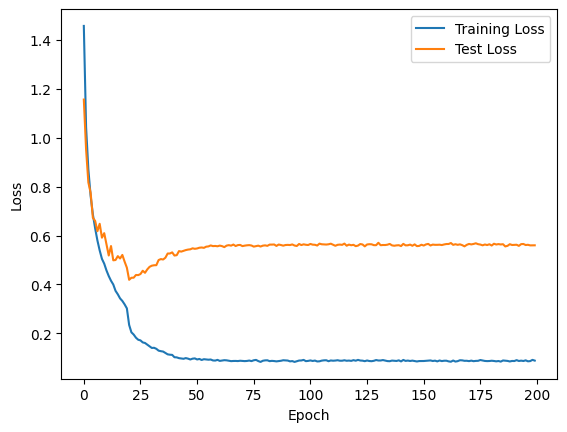

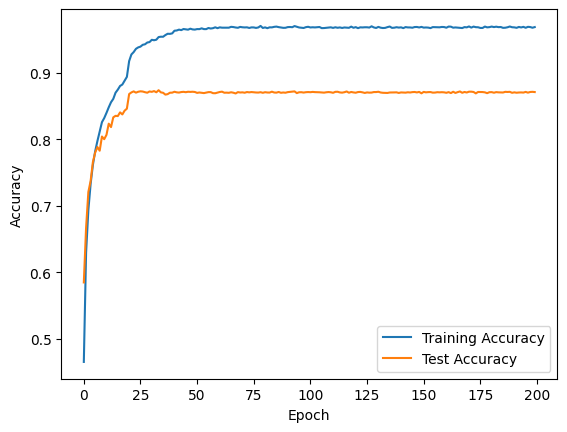

In [ ]:
import tqdm
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ExponentialLR, StepLR

#lr_scheduler = ExponentialLR(optimizer, step_size=20, gamma=0.1)
lr_scheduler = StepLR(optimizer, step_size=20, gamma=0.1)
# Initialize empty lists to store loss and accuracy values
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(200):
    model.train()
    train_loss = 0
    correct = 0
    total = 0

    # Use tqdm to track the progress of train_loader
    with tqdm.tqdm(train_loader, unit="batch") as t:
        for i, (images, labels) in enumerate(t):
            images = images.cuda()
            labels = labels.cuda()

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Update the progress bar description
            t.set_description(f"Epoch {epoch+1}")
            t.set_postfix(loss=train_loss / (i + 1), accuracy=correct / total)

    # Calculate average loss and accuracy for training set
    train_loss /= len(train_loader)
    train_accuracy = correct / total

    # Append loss and accuracy to respective lists
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    model.eval()
    test_loss = 0
    correct = 0
    total = 0

    # Use tqdm to track the progress of test_loader
    with tqdm.tqdm(test_loader, unit="batch") as t:
        for i, (images, labels) in enumerate(t):
            with torch.no_grad():
                images = images.cuda()
                labels = labels.cuda()
                outputs = model(images)
                loss = criterion(outputs, labels)

                test_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                # Update the progress bar description
                t.set_description(f"Epoch {epoch+1}")
                t.set_postfix(loss=test_loss / (i + 1), accuracy=correct / total)

    # Calculate average loss and accuracy for test set
    test_loss /= len(test_loader)
    test_accuracy = correct / total

    # Append loss and accuracy to respective lists
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

    # Update the scheduler
    lr_scheduler.step()

    current_lr = lr_scheduler.get_last_lr()[0]  # Get the current learning rate

    print('Epoch: {}, learning rate: {}, Training Loss: {:.4f}, Training Accuracy: {:.4f}, Test Loss: {:.4f}, Test Accuracy: {:.4f}'
          .format(epoch + 1, current_lr, train_loss, train_accuracy, test_loss, test_accuracy))

# Plot loss curves
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot accuracy curves
plt.plot(train_accuracies, label='Training Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
import torch
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as transforms


#Threshold Selection

model.to(device)
model.eval()

softmax_threshold = 0.0  # Initialize the threshold

# Pass the original validation set through the model to obtain softmax probabilities
with torch.no_grad():
    softmax_probs = []
    for images, _ in test_loader:
        images = images.to(device)
        outputs = model(images)
        softmax_probs.extend(torch.softmax(outputs, dim=1).max(dim=1).values.tolist())

# Sort the softmax probabilities and select the threshold
sorted_softmax_probs = sorted(softmax_probs, reverse=True)
threshold_index = int(0.95 * len(sorted_softmax_probs))
softmax_threshold = sorted_softmax_probs[threshold_index]



In [ ]:
softmax_threshold

0.6423829793930054

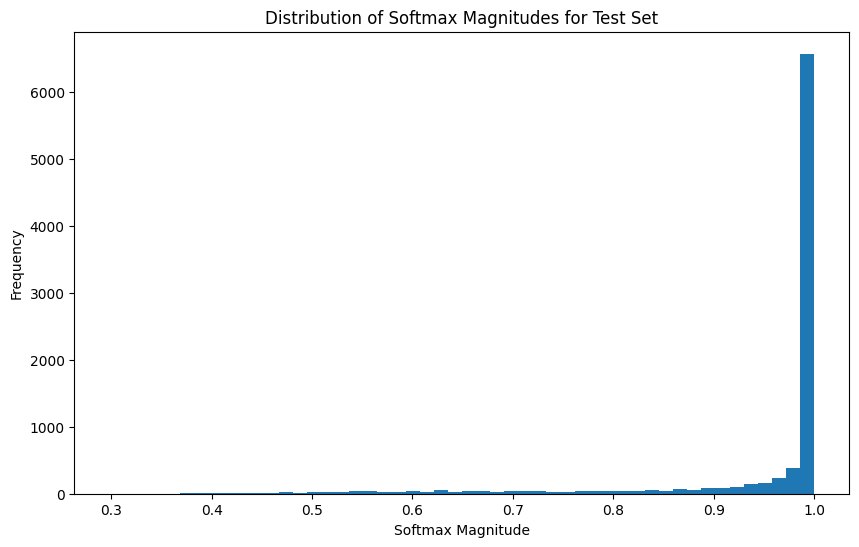

In [ ]:


import numpy as np
import matplotlib.pyplot as plt

softmax_magnitudes = []

# Iterate over the test loader and calculate the softmax magnitude for each sample
with torch.no_grad():
    for images, _ in test_loader:
        images = images.to(device)
        outputs = model(images)
        softmax_probs = torch.softmax(outputs, dim=1)
        softmax_magnitudes.extend(torch.max(softmax_probs, dim=1).values.tolist())

# Convert the softmax magnitudes to a numpy array
softmax_magnitudes = np.array(softmax_magnitudes)

# Plot the distribution of softmax magnitudes
plt.figure(figsize=(10, 6))
plt.hist(softmax_magnitudes, bins=50)
plt.xlabel('Softmax Magnitude')
plt.ylabel('Frequency')
plt.title('Distribution of Softmax Magnitudes for Test Set')
plt.show()

In [ ]:

cifar_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
frog_indices = [i for i, label in enumerate(cifar_dataset.targets) if label == 3]  # 3 represents the cat class
frog_dataset = torch.utils.data.Subset(cifar_dataset, frog_indices)

frog_dataloader_test = torch.utils.data.DataLoader(frog_dataset, batch_size=64, shuffle=False)

# Step 2: OOD Detection
ood_samples = 0
total_samples = 0

# Pass the OOD validation set (frog class) through the model and classify samples
with torch.no_grad():
    for images, _ in frog_dataloader_test:
        images = images.to(device)
        outputs = model(images)
        softmax_probs = torch.softmax(outputs, dim=1)
        max_softmax_probs, _ = softmax_probs.max(dim=1)

        ood_samples += (max_softmax_probs < softmax_threshold).sum().item()
        total_samples += len(max_softmax_probs)

ood_detection_percentage = (ood_samples / total_samples) * 100
print(f"Percentage of cat samples classified as out-of-distribution: {ood_detection_percentage}%")


Files already downloaded and verified
Percentage of cat samples classified as out-of-distribution: 15.4%


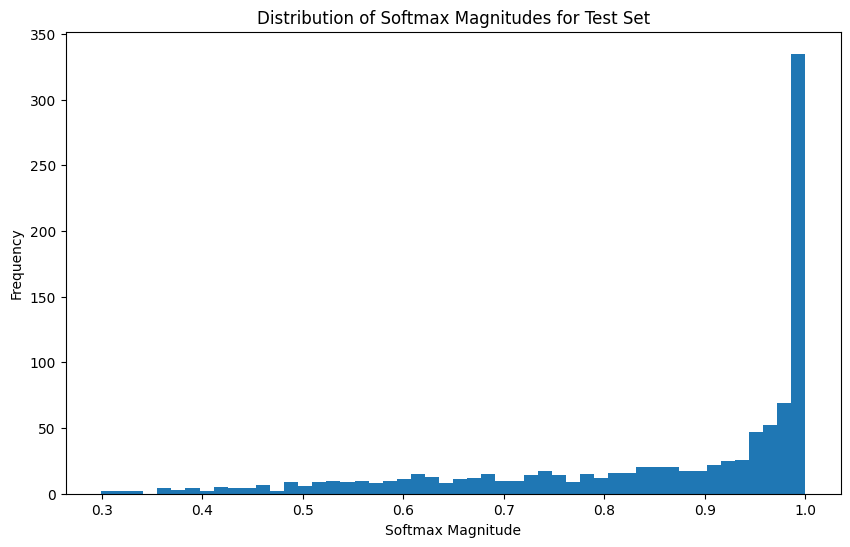

In [ ]:




import numpy as np
import matplotlib.pyplot as plt

softmax_magnitudes = []

# Iterate over the test loader and calculate the softmax magnitude for each sample
with torch.no_grad():
    for images, _ in frog_dataloader_test:
        images = images.to(device)
        outputs = model(images)
        softmax_probs = torch.softmax(outputs, dim=1)
        softmax_magnitudes.extend(torch.max(softmax_probs, dim=1).values.tolist())

# Convert the softmax magnitudes to a numpy array
softmax_magnitudes = np.array(softmax_magnitudes)

# Plot the distribution of softmax magnitudes
plt.figure(figsize=(10, 6))
plt.hist(softmax_magnitudes, bins=50)
plt.xlabel('Softmax Magnitude')
plt.ylabel('Frequency')
plt.title('Distribution of Softmax Magnitudes for Test Set')
plt.show()